## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import * # untar_data comes from here

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
# torch.cuda.set_device(3)

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images')]

In [5]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [ ]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_007470.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_008700.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_010320.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_07170_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_007170_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_006690_P.png')]

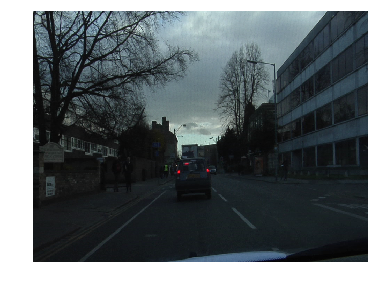

In [8]:
img_f = fnames[1]
img = open_image(img_f)
img.show(figsize=(6,6))

Mapping masks to images by guessing that the image masks have the same filename as the images, with an added '_P' at the end:

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

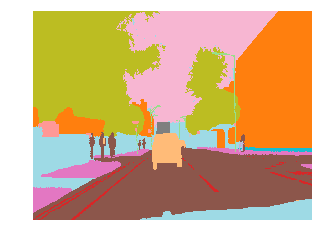

In [10]:
mask = open_mask(get_y_fn(img_f)) # use open_mask to open int-imgs, not fp-imgs
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          ...,
          [17, 10, 10,  ..., 30, 30, 30],
          [10, 10, 10,  ..., 30, 30, 30],
          [10, 10, 10,  ..., 30, 30, 30]]]))

codes.txt maps the label integer codes to their actual classes.

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [74]:
# NOTE: doesnt seem to be working
# ## clear GPU memory after CUDA out of memory error; see: https://forums.fast.ai/t/unet-learer-cuda-error/32592/8?u=borz
# learn = None
# gc.collect()

0

In [13]:
size = src_size//2
bs=4 # lecture used 8

In [14]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [15]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

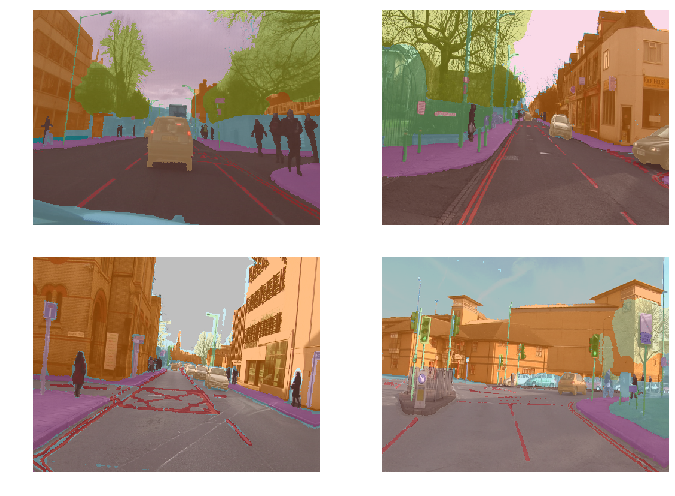

In [41]:
data.show_batch(2, figsize=(10,7))

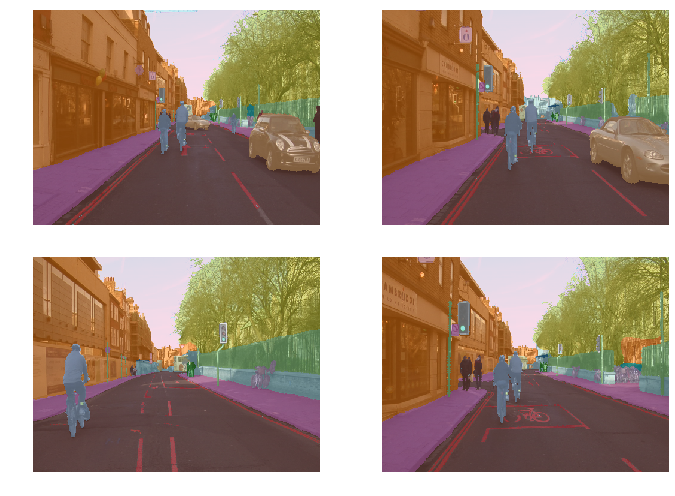

In [42]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [16]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void'] # for 'void' pixels to remove → explained in CAMVID paper

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean() # take mean argmax nonvoid

In [17]:
metrics=acc_camvid
# metrics=accuracy

In [18]:
wd=1e-2

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


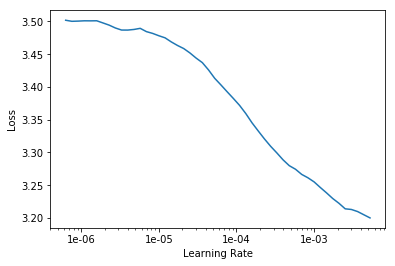

In [22]:
lr_find(learn)
learn.recorder.plot()

In [23]:
# lr=3e-3
lr = 5e-4 # lower for smaller batch size (4) on Tesla P4 GPU

In [24]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid
1,2.782944,2.570790,0.606456
2,2.592717,2.410846,0.745483
3,2.480366,2.323419,0.795622
4,2.365056,2.148207,0.791541
5,2.221448,2.014060,0.857170
6,2.064594,1.858150,0.840962
7,1.899598,1.630319,0.881592
8,1.723392,1.485939,0.888896
9,1.534562,1.316517,0.899630
10,1.366166,1.214326,0.912161


Lecture version:

    Total time: 04:34
    epoch  train_loss  valid_loss  acc_camvid
    1      2.007691    1.135577    0.756788    (00:33)
    2      1.120324    0.684148    0.836947    (00:26)
    3      0.786669    0.604433    0.836660    (00:26)
    4      0.640418    0.571276    0.846346    (00:26)
    5      0.578618    0.462487    0.871583    (00:26)
    6      0.539033    0.460834    0.869878    (00:27)
    7      0.501951    0.374874    0.892722    (00:26)
    8      0.467877    0.405072    0.897917    (00:26)
    9      0.428562    0.420552    0.878152    (00:27)
    10     0.383586    0.303194    0.916410    (00:27)

In [25]:
learn.save('stage-1')

In [41]:
learn.load('stage-1');

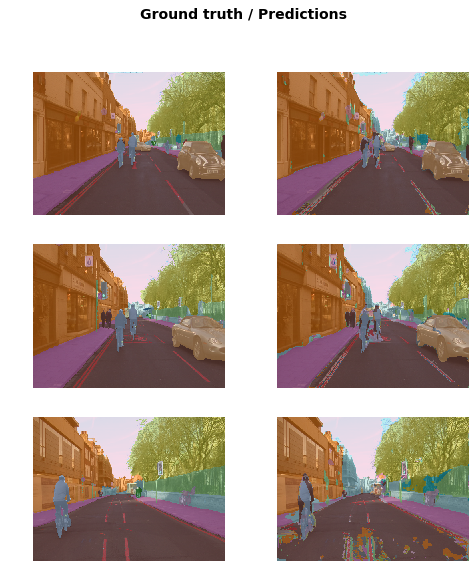

In [27]:
learn.show_results(rows=3, figsize=(8,9))

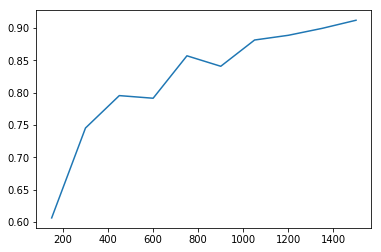

In [32]:
learn.recorder.plot_metrics()

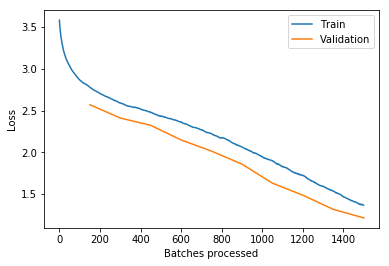

In [31]:
learn.recorder.plot_losses()

In [42]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


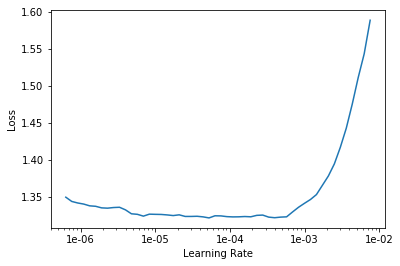

In [43]:
learn.lr_find(); learn.recorder.plot()

In [46]:
lrs = slice(lr/400,lr/4)

In [47]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,1.331500,1.202807,0.909039
2,1.336303,1.217226,0.910674
3,1.324878,1.196164,0.910578
4,1.303270,1.178764,0.914250
5,1.285780,1.152962,0.911344
6,1.256726,1.102311,0.919184
7,1.221102,1.129623,0.910529
8,1.190028,1.066859,0.920527
9,1.149783,1.031026,0.919274
10,1.111848,1.033816,0.916549


Lecture:
```
Total time: 05:41
epoch  train_loss  valid_loss  acc_camvid
1      0.371151    0.299532    0.913073    (00:28)
2      0.366780    0.294742    0.912834    (00:28)
3      0.358645    0.289903    0.914587    (00:28)
4      0.343787    0.283344    0.917667    (00:28)
5      0.335654    0.302039    0.910359    (00:28)
6      0.333715    0.279829    0.917886    (00:28)
7      0.319299    0.280948    0.919826    (00:28)
8      0.322344    0.307531    0.903787    (00:28)
9      0.308014    0.262560    0.925540    (00:28)
10     0.304060    0.293154    0.914199    (00:28)
11     0.285894    0.261870    0.923825    (00:28)
12     0.260680    0.255957    0.926067    (00:28)
```

In [48]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [19]:
size = src_size
bs=1 # in lecture: bs=3; single image uses 5445MiB/7611MiB on nv Tesla P4 GPU

In [20]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [21]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


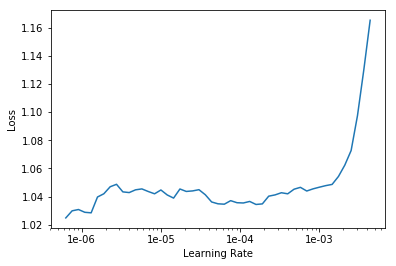

In [22]:
lr_find(learn)
learn.recorder.plot()

In [22]:
lr=2e-5 # lecture: 1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,1.378486,1.034343,0.899727
2,1.341163,1.009340,0.903653
3,1.325512,1.003621,0.904017
4,1.302691,0.946851,0.913839
5,1.295025,0.949263,0.910848
6,1.252703,0.968370,0.907161


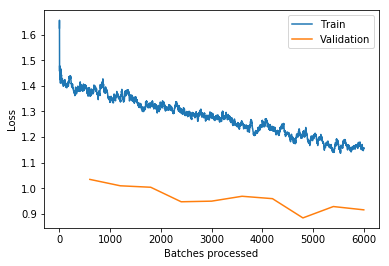

In [25]:
learn.recorder.plot_losses()

Jupyter Lab sort-of crashed twice/three-times here, but the kernel .. never died? Pulling up the last run's loss plots looks to be in line with a completed run... so I'm thinking that just the graphical portion of Jupyter Lab cut out, and that the model itself completed its training run. Hopefully. Although there isn't a loss printout now.

Lecture: 
```
Total time: 15:41
epoch  train_loss  valid_loss  acc_camvid
1      0.382982    0.337384    0.904437    (01:40)
2      0.363525    0.312738    0.913709    (01:33)
3      0.345842    0.281208    0.918837    (01:33)
4      0.332908    0.315401    0.911936    (01:33)
5      0.337121    0.315564    0.911719    (01:33)
6      0.326914    0.283248    0.919347    (01:33)
7      0.311748    0.303021    0.913213    (01:33)
8      0.312433    0.264381    0.925357    (01:33)
9      0.274042    0.265071    0.921500    (01:33)
10     0.244084    0.239709    0.931215    (01:33)
```

In [26]:
learn.save('stage-1-big')

In [27]:
learn.load('stage-1-big');

In [28]:
learn.unfreeze()

In [29]:
lrs = slice(1e-6,lr/10)

In [30]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,1.143033,0.904328,0.918026
2,1.146393,0.912714,0.918111
3,1.145190,0.909793,0.916554
4,1.148593,0.918375,0.914671
5,1.119453,0.919883,0.915622
6,1.157662,0.867033,0.920864
7,1.127480,0.883603,0.920396
8,1.161041,0.870517,0.922683
9,1.110687,0.920541,0.918841
10,1.155454,0.893379,0.920776


No jupyter glitches this time. I can obviously train this more since it's still underfit, but it's 3am and I'm just making sure I can go along with the lecture and understand what's up, so I'm leaving it as is.

Lecture:

```
Total time: 16:49
epoch  train_loss  valid_loss  acc_camvid
1      0.224315    0.243748    0.929659    (01:39)
2      0.233819    0.256230    0.925163    (01:41)
3      0.216598    0.248363    0.929304    (01:41)
4      0.217467    0.242487    0.930903    (01:41)
5      0.221290    0.247053    0.930387    (01:41)
6      0.208421    0.249250    0.929263    (01:41)
7      0.202845    0.240715    0.931511    (01:41)
8      0.197734    0.244688    0.930260    (01:41)
9      0.195650    0.249368    0.929931    (01:40)
10     0.192460    0.248666    0.929322    (01:41)
```

In [42]:
next(iter(learn.data.single_dl))[0].shape
# the fullsize are 960x720 iamges

torch.Size([1, 3, 720, 960])

In [43]:
learn.save('stage-2-big')

In [39]:
learn.load('stage-2-big');

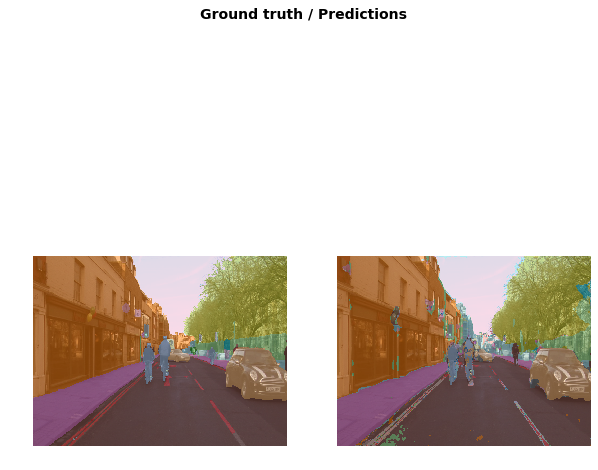

In [47]:
learn.load('stage-2-big');
learn.show_results(rows=1, figsize=(10,10))

It's good ot see it working; but I want it to do better. I'll try a more aggressive learning rate and see how that does.

In [45]:
learn.load('stage-1-big');
learn.unfreeze()
lr=1e-4 # up from 2e-5; trying more aggressive lr
lrs = slice(1e-6,lr/10)
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,1.142523,0.925284,0.916076


KeyboardInterrupt: 

In [ ]:
learn.save('stage-2-big-lr1e-4')

In [ ]:
learn.show_results(rows=1, figsize=(10,10))

Lecture results:

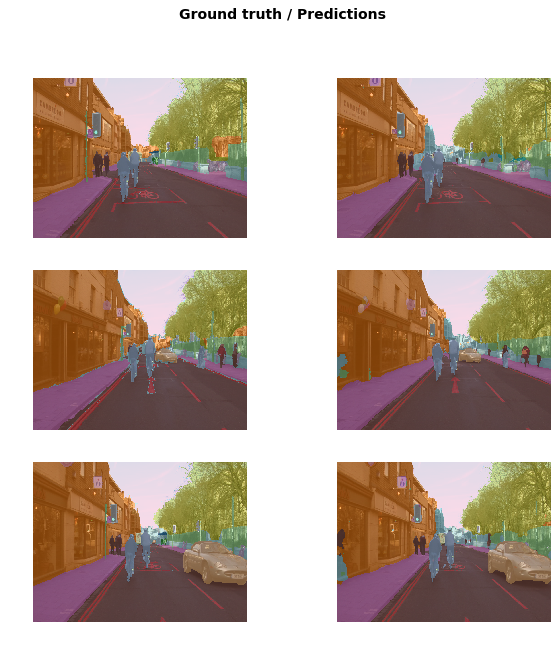

In [ ]:
# learn.show_results(rows=3, figsize=(10,10))

## fin